# Gene Regulation III - Workshop
## *aka* Gene Regulatory Network (GRN)
UMass Chan GSBS BBS764

*Lingfei Wang*

2025-03-03

## Introduction
* Paper: [Gene regulatory network inference from CRISPR perturbations in primary CD4+ T cells elucidates the genomic basis of immune disease](https://www.cell.com/cell-genomics/fulltext/S2666-979X\(24\)00290-8).
* Study design: Bulk RNA-seq of samples with CRISPR targeted KO on select genes and control.
* Data: tsv.gz file containing differential expression results between samples with each target gene KOed (3 samples each) and the same control (27 samples). Preprocessed from supplementary material of its [biorxiv preprint](https://www.biorxiv.org/content/10.1101/2023.09.17.557749v2.supplementary-material).
* Goal:	Reconstructing a gene regulatory network with causal inference.

## Practicalities
* No attendance sheet requirement: if uninterested/not useful/done, **leave any time**.
* **Open the slides** and download and open the notebook. Use the slides for reference.
* You task is to read, understand, write when needed, and run each code block sequentially.
* You should write the '???' areas in two types:
  1. Single-line code starting with `##### Your code:`. Remove characters before and including ':'. Extra lines is not needed but allowed.
  2. Multi-line code starting with `#### Your code starts here ####` and ends with `##### Your code ends here #####`
* If your code is correct, you should get the same output as in the slides.
* **Keep going** for 1.5h or until you complete the final slide.
* I am available to answer questions any time.

## How: imagine you are doing research
* First learn to DIY: google, github copilot & ChatGPT
* Then ask someone who might have completed this code block. **Move around if needed**.
* If everything fails, ask me.
* The right (*aka* working) solution is not unique.

## TOC
Hypothesis: $P$-|$A$->$B$ or $P$-|$A$-|$B$
1. Load differential expression (DE) results
2. List CRISPR perturbations $\{P_A\}$, each targeting a KOed gene $A$
3. For each perturbation $P_A$, check $P_A$-|$A$ in DE results and retain only if $P_A$ gives significant repression
4. For each remaining perturbation $P_A$ and each gene B, if $P_A$->$B$ or $P_A$-|$B$ in DE results, introduce edge $A$-|$B$ or $A$->$B$ into our network
5. Save network to file
6. Analyze network
7. Visualize network with Cytoscape

## 0. Preparation
1. Create folder `run` in the same directory as this notebook.
2. Download `https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/run/processed.tsv.gz` into folder `run` and name it as `processed.tsv.gz`.

In [1]:
from os.path import isfile
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# Input and output file paths
path_in='run/processed.tsv.gz'
path_out='run/grn.tsv'
# Check if input file exists
if not isfile(path_in):
	raise NotImplementedError(f"File {path_in} not found.")

## 1. Load DE results

In [2]:
#### Your code:df=pd.read_csv(???)
df.head(3)

,gene,target,p,lfc
0,ISG15,AKAP8,0.385355,-0.251955
1,ACOT7,AKAP8,0.349425,-0.264555
2,TNFRSF25,AKAP8,0.277335,0.236204


Column definitions
* gene: The gene whose differential expression results are shown on this row.
* target: This row includes differential expression results computed between samples with this gene targeted for KO v.s. controls.
* p: Differential expression P-value. For the perturbed gene (when column `gene` is the same as `target`), this is raw P-value. For other genes, this is adjusted P-value.
* lfc: Differential expression log2 fold change.

## 2. List perturbations and DE results of associated genes

In [3]:
# Whether each row is the DE results of a gene targeted by the CRISPR KO
#### Your code:is_target=???
# Extract DE results of targeted genes
df_target_initial=df[is_target].set_index('target',drop=True).drop(columns=['gene'])
df_target_initial

,p,lfc
target,,
AKAP8,3.611740e-14,-0.831944
ARID5A,2.570915e-02,0.274388
ATXN7L3,2.849576e-03,0.242471
BPTF,1.747578e-36,-0.778508
CBFB,1.005515e-153,-1.723185
...,...,...
ZKSCAN1,2.101872e-30,-1.034257
ZNF217,1.588385e-27,-0.845768
ZNF319,3.180268e-14,0.900860


## 3. Check $P_A-|A$ visually with volcano plot

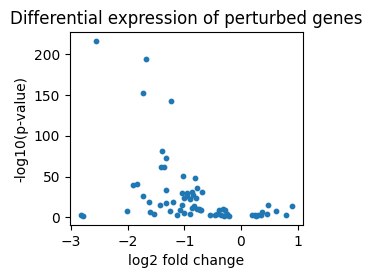

In [4]:
fig,ax=plt.subplots(figsize=(3,2.5))
# Draw scatter plot of log2 fold change vs -log10(p-value)
#### Your code:ax.scatter(???,s=10)
ax.set_xlabel('log2 fold change');ax.set_ylabel('-log10(p-value)')
ax.set_title('Differential expression of perturbed genes'); plt.show()


Some CRISPR KO perturbations may be ineffective with lfc>0 or large P-value. We will remove them.

## 3. Find perturbations with significant repression

In [5]:
# Raw P value cutoff for differential expression of targeted gene A
cut_p_target=1E-5
# LogFC cutoff for differential expression of targeted gene A
cut_lfc_target=0.5
# Identify perturbations leading to significant repression of the targeted gene
#### Your code:is_repression=(df_target_initial['p']<=???)&(???)
# Extract perturbations leading to significant repression
targets=df_target_initial.index[is_repression]
targets

Index(['AKAP8', 'BPTF', 'CBFB', 'CLOCK', 'ELK4', 'EPAS1', 'ETS1', 'FOXK1',
       'FOXP1', 'GATA3', 'IL2RA', 'IRF2', 'JAK3', 'KLF9', 'KMT2A', 'MBD2',
       'MED12', 'NFE2L3', 'NFKB1', 'PTEN', 'REL', 'RELA', 'RELB', 'RORC',
       'SETDB1', 'SREBF1', 'STAT1', 'STAT2', 'STAT3', 'STAT5A', 'STAT5B',
       'TBX21', 'TCF3', 'TP53', 'TTF1', 'YBX1', 'YY1', 'ZBTB24', 'ZKSCAN1',
       'ZNF217'],
      dtype='object', name='target')

## 3. Retain perturbations with significant repression

In [6]:
# Filter DE results of targeted genes with perturbations leading to significant repression
df_target=df_target_initial.loc[targets]
# Filter DE results of untargeted genes with perturbations leading to significant repression
#### Your code:df=df[???]
df.shape

(67305, 4)

## 4. Test $P_A$->$B$ or $P_A$-|$B$ - parameters

In [7]:
# Adjusted P value cutoff for differential expression of untargeted genes
cut_p=0.05
# LogFC cutoff for differential expression of untargeted genes
cut_lfc=0.5

## 4. Test $P_A$->$B$ or $P_A$-|$B$ - 1 perturbation
Part I: Extracting DE results for this perturbation

In [8]:
# Initialize empty list of edges
edges=[]
# Use the first targeted gene to try your code
target=targets[0]
# Extract differential expression results for the targeted gene
#### Your code: s_target=???
# Extract differential expression results for the first perturbation
#### Your code:df1=df[???]
# Extract differential expression results for untargeted genes
#### Your code: df1_other=df1[???]
print(s_target)
df1_other.head(2)

p      3.611740e-14
lfc   -8.319442e-01
Name: AKAP8, dtype: float64


,gene,target,p,lfc
0,ISG15,AKAP8,0.385355,-0.251955
1,ACOT7,AKAP8,0.349425,-0.264555


## 4. Test $P_A$->$B$ or $P_A$-|$B$ - 1 perturbation
Part II: finding significant DEs

In [9]:
# Identify which genes are differentially expressed due to the perturbation
#### Your code:is_de=(???)&(???)
# Extract differentially expressed genes due to this perturbation
df1_de=df1_other[is_de]
# Use a loop to create edges in the GRN, one at a time iteratively from the targeted gene to each differentially expressed gene
for idx in df1_de.index:
	# Starting node of the edge
	#### Your code:node_start=???
	# Ending node of the edge
	#### Your code:node_end=???
	# Weight of the edge
	#### Your code:edge_weight=???
	# Add the edge
	edges.append((node_start,node_end,edge_weight))
print('Number of edges:',len(edges))
edges[:3]

Number of edges: 2


[('AKAP8', 'TSC22D4', np.float64(-0.6880808472308385)),
 ('AKAP8', 'FRMD8', np.float64(0.6606878405909893))]

## 4. Now use a loop to iterate over all remaining perturbations

In [10]:
# Re-initialize empty list of edges
edges=[]
for target in targets:
	# Paste all your code in above two code blocks after the line `target=targets[0]`. Exclude `print` lines. Increase indentation.
	#### Your code starts here ####
	???
	##### Your code ends here #####
print('Number of edges:',len(edges))
edges[-3:]

Number of edges: 10418


[('ZNF217', 'BCORP1', np.float64(-0.8909980321828219)),
 ('ZNF217', 'ENSG00000289707', np.float64(-0.6030418232529909)),
 ('ZNF217', 'MT-TI', np.float64(0.6806038568444858))]

## 4. Create pandas.Dataframe and networkx.DiGraph objects

In [11]:
df_grn=pd.DataFrame(edges,columns=['source','target','weight'])
grn=nx.from_pandas_edgelist(df_grn,source='source',target='target',edge_attr='weight',create_using=nx.DiGraph())
df_grn.head()

,source,target,weight
0,AKAP8,TSC22D4,-0.688081
1,AKAP8,FRMD8,0.660688
2,BPTF,ENSG00000217801,-0.999683
3,BPTF,ZNF593,1.284137
4,BPTF,TMEM39B,0.777404


## 5. Save network to file
We have a minimal scenario where only an edge property file needs to be saved. More complex questions may also give rise to node properties such as expression level of each gene we want to consider altogether. They can be similarly saved as another file. The edge and node property files can then be loaded into Cytoscape. [Cytoscape](https://cytoscape.org/) is a very popular gene network analysis and visualization software. We will not look into it in this workshop.

In [12]:
# Save edge properties into tsv file
#### Your code:df_grn.to_csv(path_out,???)
# Show the first 4 lines of the file
with open(path_out,'r') as f:
	for _ in range(4):
		print(f.readline().rstrip())

source	target	weight
AKAP8	TSC22D4	-0.6880808472308385
AKAP8	FRMD8	0.6606878405909893
BPTF	ENSG00000217801	-0.9996829704895553


## 5. Install Cytoscape (optional)
If you have reached here and want to eventually explore network visualization with Cytoscape in step 7, download and install [Cytoscape](https://cytoscape.org/) now while you work on step 6.

## 6. Basic properties of the network

In [13]:
# Number of nodes
#### Your code:nn=???
# Number of edges
#### Your code:ne=???
# Out-degree (number of target genes)
#### Your code:odegree=???
# Convert to pandas.Series
odegree=pd.Series(dict(odegree))
# Limit to nodes with at least one target
#### Your code:odegree=odegree[???]
# Sort out-degree in descending order
#### Your code:???
# Create a dataframe of nodes with network information
df_nodes=pd.DataFrame(odegree,index=odegree.index,columns=['outdegree'])
print(f'Number of nodes/regulators/edges: {nn}/{len(odegree)}/{ne}')
odegree.head()

Number of nodes/regulators/edges: 5100/34/10418


CBFB     2052
MED12    1787
YY1      1038
ETS1      752
PTEN      687
dtype: int64

## 6. Plot out-degree distribution

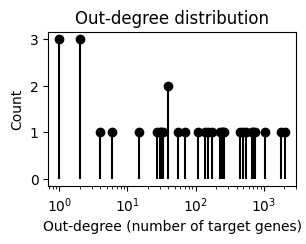

In [14]:
fig,ax=plt.subplots(figsize=(3.2,2))
outdegree_values=list(odegree.values)
occurence=[outdegree_values.count(x) for x in set(outdegree_values)]
ax.stem(list(set(outdegree_values)),occurence,linefmt='black',markerfmt='ko',basefmt='none')
ax.set_xscale('log')
ax.set_xlabel('Out-degree (number of target genes)');ax.set_ylabel('Count')
ax.set_title('Out-degree distribution'); plt.show()

The number of targets varies greatly between different perturbed genes.

## 6. Redraw valcano plot with out-degree

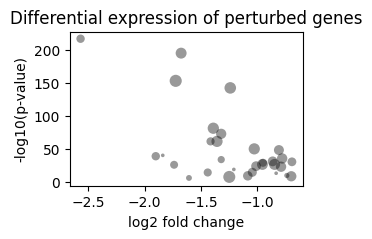

In [15]:
# Merge with differential expression results
#### Your code:df_volcano=pd.merge(...,df_nodes,left_index=True,right_index=True,how='inner')
fig,ax=plt.subplots(figsize=(3,2))
# Draw scatter plot of log2 fold change vs -log10(p-value)
#### Your code:df_volcano['lfc'],-np.log10(df_volcano['p']),s=np.log(df_volcano[...])*10,c='k',alpha=0.4,lw=0
ax.set_xlabel('log2 fold change');ax.set_ylabel('-log10(p-value)')
ax.set_title('Differential expression of perturbed genes'); plt.show()


Target gene count does not strongly depend on DE strength of the perturbed genes. This is reassuring and indicating our results are not biased by KO quality.

## 7. Load network into Cytoscape
Open Cytoscape. Go here:
<img src="img/c1.png" style="display: block; margin-left: auto; margin-right: auto;" width="550" onerror="this.onerror=null; this.src='https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/img/c1.png';"/>
Then choose your `run/grn.tsv` file.


## 7. Assign column properties
Make sure they show as below. If not, click on the column headers to change them.
<img src="img/c2.png" style="display: block; margin-left: auto; margin-right: auto;" width="800" onerror="this.onerror=null; this.src='https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/img/c2.png';"/>
After clicking OK, Cytoscape may take some time to calculate the layout, which is the position of each node. Then you will see something like a light blue disc.

## 7. Show network details
Actually the blue disc is the collection of nodes of the network. You can show network details with:
<img src="img/c3.png" style="display: block; margin-left: auto; margin-right: auto;" width="400" onerror="this.onerror=null; this.src='https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/img/c3.png';"/>
Then you can zoom in/out with control/command+mouse scroll.

## 7. Search for a gene
On the top right, you can search for a node by name.
<img src="img/c4.png" style="display: block; margin-left: auto; margin-right: auto;" width="400" onerror="this.onerror=null; this.src='https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/img/c4.png';"/>
Try searching for STAT1. STAT1 will be highlighted in yellow and its edges in red. However, some of them can be blocked by other genes.
<img src="img/c5.png" style="display: block; margin-left: auto; margin-right: auto;" width="200" onerror="this.onerror=null; this.src='https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/img/c5.png';"/>

## 7. Get a subnetwork
Make sure STAT1 is still selected. If not, search for it again. Then select its target genes in the network:
<img src="img/c6.png" style="display: block; margin-left: auto; margin-right: auto;" width="500" onerror="this.onerror=null; this.src='https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/img/c6.png';"/>
You can see more genes are highlighted due to selection. Then get a subnetwork of these genes:
<img src="img/c7.png" style="display: block; margin-left: auto; margin-right: auto;" width="250" onerror="this.onerror=null; this.src='https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/img/c6.png';"/>


## 7. Show arrow direction
The subnetwork is now clearer. But it's still unclear which gene regulates which because edge direction is not visible:
<img src="img/c8.png" style="display: block; margin-left: auto; margin-right: auto;" width="200" onerror="this.onerror=null; this.src='https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/img/c8.png';"/>
Let's go to visualization style

<img src="img/c9.png" width="200" onerror="this.onerror=null; this.src='https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/img/c9.png';"/> <img src="img/c10.png" width="300" onerror="this.onerror=null; this.src='https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/img/c10.png';"/>

Then change "Target Arrow Shape" to this:
<img src="img/c11.png" style="display: block; margin-left: auto; margin-right: auto;" width="200" onerror="this.onerror=null; this.src='https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/img/c11.png';"/>


## 7. Change edge color
We can show gene activation/repression with red/blue colors. Unfold "Stroke Color (Unselected)":
<img src="img/c12.png" style="display: block; margin-left: auto; margin-right: auto;" width="400" onerror="this.onerror=null; this.src='https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/img/c12.png';"/>
This allows us to color each edge based its columns. Here we want the color to depend on edge weight, which is how much the target gene's log2FC per regulator's log2FC. 
<img src="img/c13.png" style="display: block; margin-left: auto; margin-right: auto;" width="400" onerror="this.onerror=null; this.src='https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/img/c13.png';"/>
Let's make the color change continuously.
<img src="img/c14.png" style="display: block; margin-left: auto; margin-right: auto;" width="400" onerror="this.onerror=null; this.src='https://raw.githubusercontent.com/grnlab/courses/refs/heads/master/2025_BBS764/img/c14.png';"/>


## 8. The END
Congratulations! You've completed this workshop.

Homework will be available later today over slack. It will be ungraded.